In [1]:
from splink.duckdb.duckdb_linker import DuckDBLinker

In [2]:
import pandas as pd 
pd.options.display.max_rows = 1000
df = pd.read_parquet("./data/historical_figures_with_errors_50k.parquet")
df.head(5)

,uncorrupted_record,cluster,full_name,dob,birth_place,postcode_fake,lat,lng,gender,occupation,unique_id
0,True,Q2296770,"thomas clifford, 1st baron clifford of chudleigh",1630-08-01,Devon,TQ13 8DF,50.692449,-3.813964,male,politician,Q2296770-1
1,False,Q2296770,thomas of chudleigh,1630-08-01,Devon,TQ13 8DF,50.692449,-3.813964,male,politician,Q2296770-2
2,False,Q2296770,tom 1st baron clifford of chudleigh,1630-08-01,Devon,TQ13 8DF,50.692449,-3.813964,male,politician,Q2296770-3
3,False,Q2296770,thomas 1st chudleigh,1630-08-01,Devon,TQ13 8HU,50.687638,-3.895877,None,politician,Q2296770-4
4,False,Q2296770,"thomas clifford, 1st baron chudleigh",1630-08-01,Devon,TQ13 8DF,50.692449,-3.813964,None,politician,Q2296770-5


In [3]:
import numpy as np
import pandas as pd

def clean_df(df):
    cols = [
        "unique_id",
        "cluster",
        "full_name",
        "dob",
        "birth_place",
        "postcode_fake",
        "gender",
        "occupation",
    ]

    df = df[cols].copy()

    df["name_split"] = df["full_name"].str.strip().str.split(" ")
    df["name_split_length"] = df["name_split"].str.len()
    df["first_name"] = df["name_split"].str[0]
    df["surname"] = df["name_split"].str[-1]
    df["surname"] = np.where(df["name_split_length"] > 1, df["surname"], "")
    # df["middle_names"] = df["name_split"].str[1:-1]

    df["first_and_surname"] = df["first_name"] + " " + df["surname"]

    for col in [
        "full_name",
        "first_and_surname",
        "first_name",
        "surname",
        "dob",
        "birth_place",
        "postcode_fake",
        "gender",
        "occupation",
    ]:
        df[col] = df[col].str.lower().str.strip()
        df[col] = df[col].replace({"": None})

    cols = [
        "unique_id",
        "cluster",
        "full_name",
        "first_and_surname",
        "first_name",
        "surname",
        "dob",
        "birth_place",
        "postcode_fake",
        "gender",
        "occupation",
    ]
    return df[cols]


df_clean = clean_df(df)
df_clean.head(2)

,unique_id,cluster,full_name,first_and_surname,first_name,surname,dob,birth_place,postcode_fake,gender,occupation
0,Q2296770-1,Q2296770,"thomas clifford, 1st baron clifford of chudleigh",thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8df,male,politician
1,Q2296770-2,Q2296770,thomas of chudleigh,thomas chudleigh,thomas,chudleigh,1630-08-01,devon,tq13 8df,male,politician


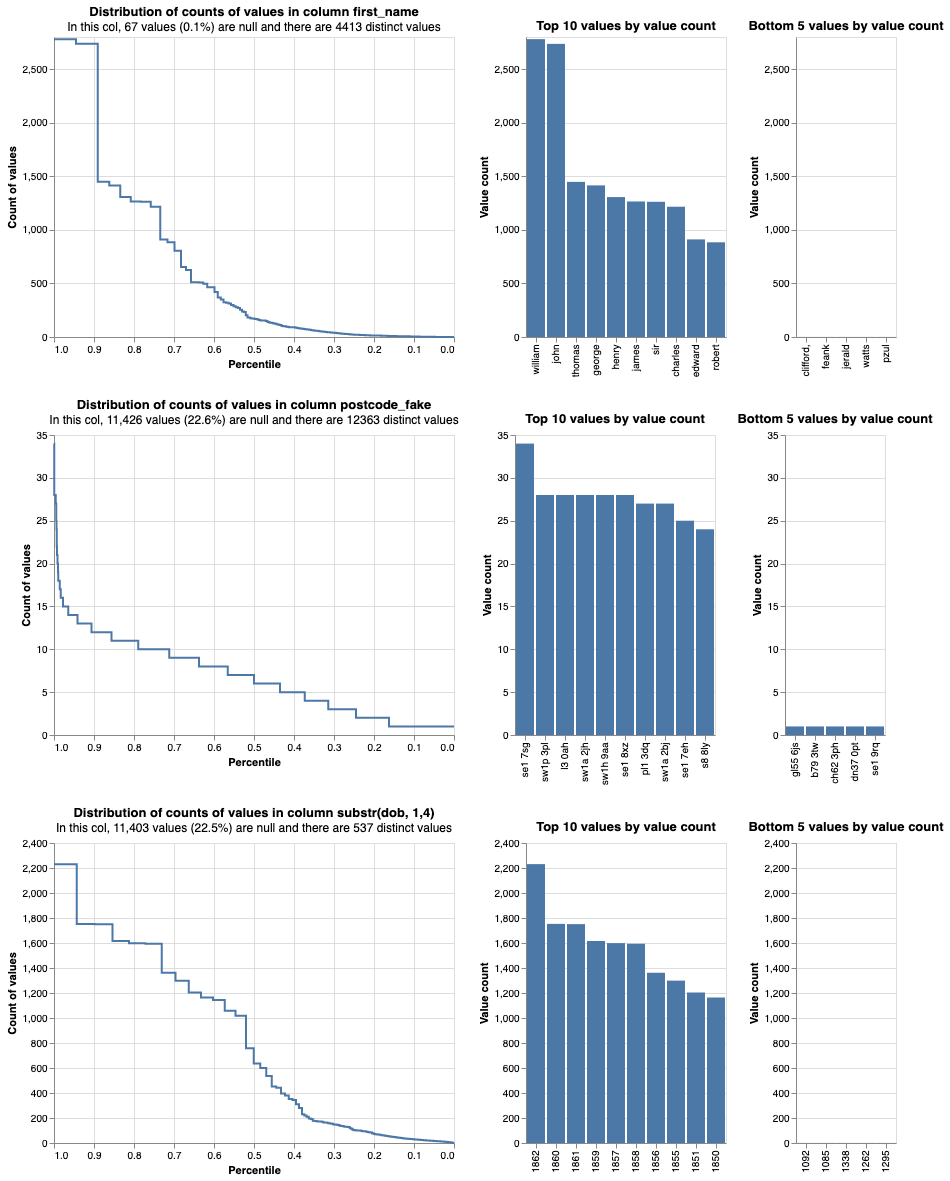

In [4]:
# Initialise the linker, passing in the input dataset(s)
linker = DuckDBLinker(df_clean)

import altair as alt
alt.renderers.enable('mimetype')
linker.profile_columns(["first_name", "postcode_fake", "substr(dob, 1,4)"], top_n=10, bottom_n=5)

In [5]:
linker.analyse_blocking_rule("l.first_name = r.first_name")

{'count_of_pairwise_comparisons_generated': 16372982}

In [6]:
linker.analyse_blocking_rule("l.first_name = r.first_name and l.surname = r.surname",)

{'count_of_pairwise_comparisons_generated': 243656}

In [7]:

from splink.comparison_library import exact_match, levenshtein
settings = {
    "proportion_of_matches": 1e-5,
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name and l.surname = r.surname",
        "l.surname = r.surname and l.dob = r.dob",
        "l.first_name = r.first_name and l.dob = r.dob",
        "l.postcode_fake = r.postcode_fake and l.first_name = r.first_name",
    ],
    "comparisons": [
        levenshtein("first_name", 2, term_frequency_adjustments=True),
        levenshtein("surname", 2, term_frequency_adjustments=True),
        levenshtein("dob", 2, term_frequency_adjustments=True),
        levenshtein("postcode_fake", 2),
        exact_match("birth_place", term_frequency_adjustments=True),
        exact_match("occupation",  term_frequency_adjustments=True),
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
    "max_iterations": 10,
    "em_convergence": 0.01
}

In [8]:
linker.initialise_settings(settings)
linker.train_u_using_random_sampling(target_rows=4e6)

----- Training u probabilities using random sampling -----

Trained u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trained).
    - dob (no m values are trained).
    - postcode_fake (no m values are trained).
    - birth_place (no m values are trained).
    - occupation (no m values are trained).



----- Starting EM training session -----

Training the m probabilities of the model by blocking on:
l.first_name = r.first_name and l.surname = r.surname

Parameter estimates will be made for the following comparison(s):
    - dob
    - postcode_fake
    - birth_place
    - occupation

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - first_name
    - surname

Iteration 1: Largest change in params was -0.187 in the m_probability of postcode_fake, level `Levenstein <= 2`
Iteration 2: Largest change in params was 0.0231 in the m_probability of postcode_fake, level `All other comparisons`
Iteration 3: Largest change in params was -0.00576 in the m_probability of birth_place, level `Exact match`

EM converged after 3 iterations

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trained).


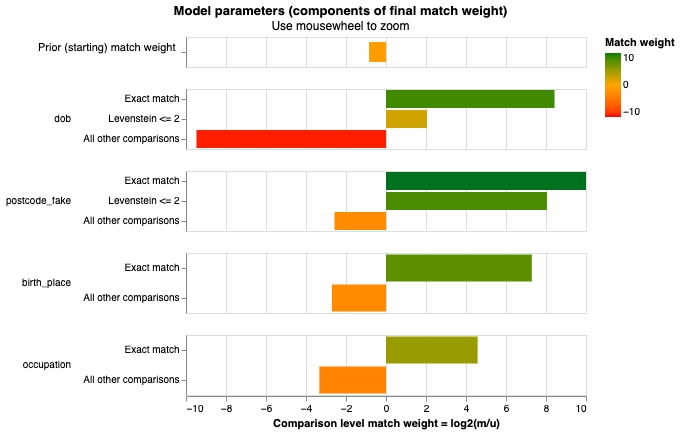

In [9]:
blocking_rule = "l.first_name = r.first_name and l.surname = r.surname"
training_session_names = linker.train_m_using_expectation_maximisation(blocking_rule)
training_session_names.match_weights_interactive_history_chart()


----- Starting EM training session -----

Training the m probabilities of the model by blocking on:
l.dob = r.dob

Parameter estimates will be made for the following comparison(s):
    - first_name
    - surname
    - postcode_fake
    - birth_place
    - occupation

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - dob

Iteration 1: Largest change in params was 0.196 in the m_probability of first_name, level `All other comparisons`
Iteration 2: Largest change in params was 0.0508 in the m_probability of first_name, level `All other comparisons`
Iteration 3: Largest change in params was 0.00693 in the m_probability of first_name, level `All other comparisons`

EM converged after 3 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


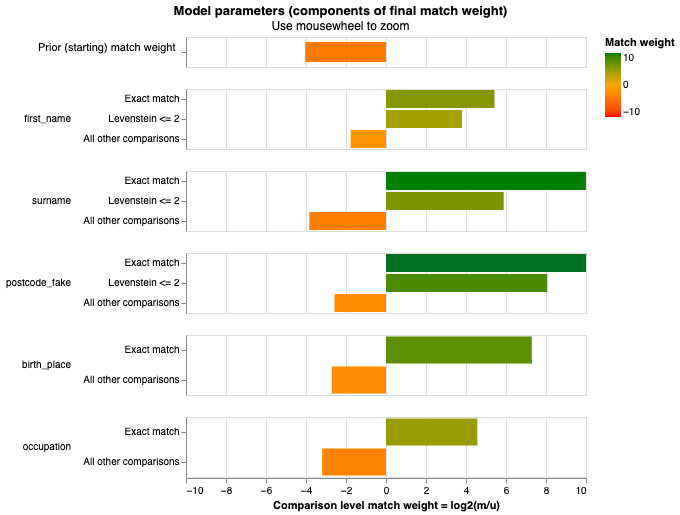

In [10]:
blocking_rule = "l.dob = r.dob"
training_session_dob = linker.train_m_using_expectation_maximisation(blocking_rule)
training_session_dob.match_weights_interactive_history_chart()

The final match weights can be viewed in the match weights chart:

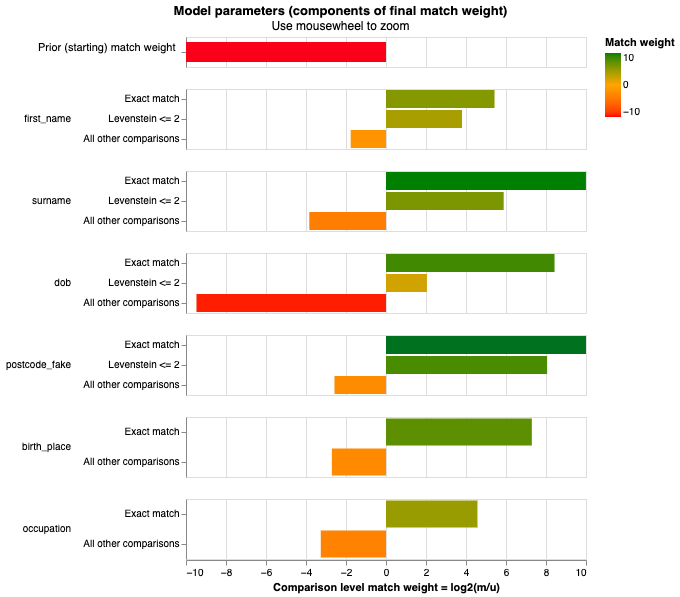

In [11]:
linker.settings_obj.match_weights_chart()

In [12]:
df_e = linker.predict().as_pandas_dataframe()

print(f"{len(df_e):,.0f}")

307,023


In [13]:
df_e.head(5)

,match_weight,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,bf_first_name,bf_tf_adj_first_name,tf_first_name_l,...,tf_birth_place_l,tf_birth_place_r,occupation_l,occupation_r,gamma_occupation,bf_occupation,bf_tf_adj_occupation,tf_occupation_l,tf_occupation_r,match_key
0,23.018589,1.0,Q2296770-1,Q2296770-10,thomas,thomas,2,43.001553,0.448402,0.028667,...,0.001260,0.001260,politician,politician,1,23.808295,0.424893,0.088932,0.088932,0
1,39.606385,1.0,Q1443188-1,Q1443188-3,frank,frank,2,43.001553,2.029020,0.006335,...,0.003872,0.004124,liturgist,liturgist,1,23.808295,159.264052,0.000237,0.000237,0
2,39.606385,1.0,Q1443188-2,Q1443188-3,frank,frank,2,43.001553,2.029020,0.006335,...,0.003872,0.004124,liturgist,liturgist,1,23.808295,159.264052,0.000237,0.000237,0
3,40.790207,1.0,Q90404618-1,Q90404618-3,emlie,emlie,2,43.001553,129.857286,0.000099,...,0.001008,0.001008,playwright,playwright,1,23.808295,13.849048,0.002728,0.002728,0
4,40.790207,1.0,Q90404618-2,Q90404618-3,emlie,emlie,2,43.001553,129.857286,0.000099,...,0.001008,0.001008,playwright,playwright,1,23.808295,13.849048,0.002728,0.002728,0


You can also view rows in this dataset as a waterfall chart as follows:

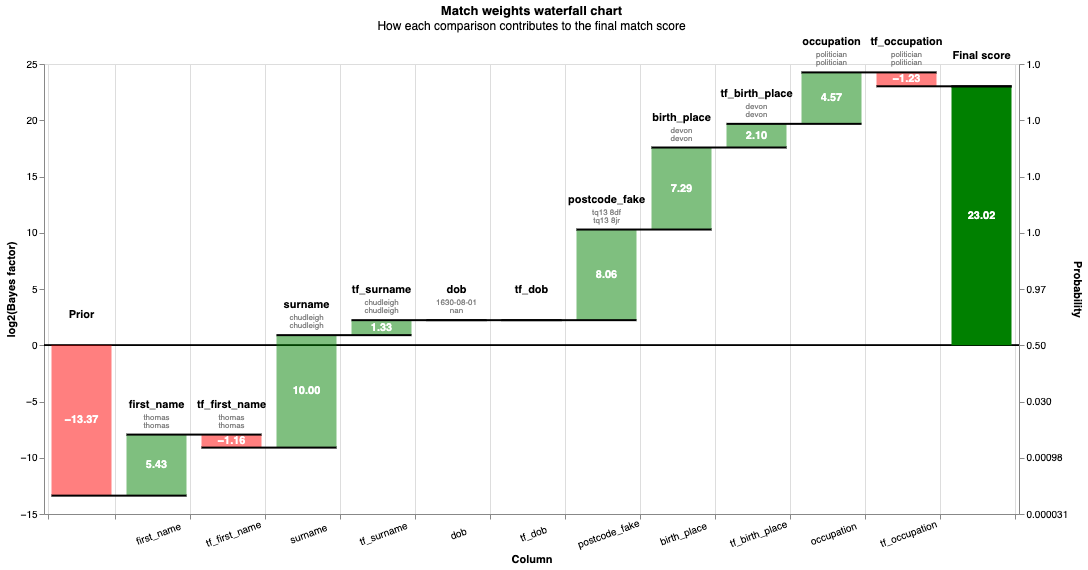

In [14]:
from splink.charts import waterfall_chart
records_to_plot = df_e.head(50).to_dict(orient="records")
waterfall_chart(records_to_plot, linker.settings_obj, filter_nulls=False)

In [15]:
pd.DataFrame([records_to_plot[0]])

,match_weight,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,bf_first_name,bf_tf_adj_first_name,tf_first_name_l,...,tf_birth_place_l,tf_birth_place_r,occupation_l,occupation_r,gamma_occupation,bf_occupation,bf_tf_adj_occupation,tf_occupation_l,tf_occupation_r,match_key
0,23.018589,1.0,Q2296770-1,Q2296770-10,thomas,thomas,2,43.001553,0.448402,0.028667,...,0.00126,0.00126,politician,politician,1,23.808295,0.424893,0.088932,0.088932,0
